# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import warnings

# warnings.filterwarnings("ignore")
from ast import literal_eval
import json
import os
from pathlib import Path
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
# import torch
from typing import List, Dict
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

In [ ]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/home/kevin/code/rycolab/measureLM'

In [ ]:
from analysis_helpers import (
    add_val_df_to_wandb,
    construct_df_given_query_id,
    load_val_df_from_wandb,
    permutation_test,
    percent_ents_passing_pscore_permutation_test,
)
from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from utils import load_artifact_from_wandb, construct_paths_and_dataset_kwargs

### Preamble

In [ ]:
# sns.color_palette("colorblind")
# print(sns.color_palette("colorblind").as_hex())

'Bitstream Vera Sans'

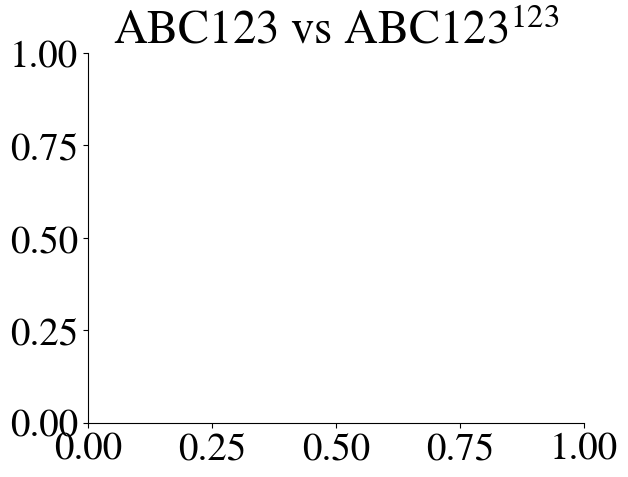

In [ ]:
from mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

In [ ]:
##############
# Parameters #
##############
CONFIG_PATH = "analysis/config-s8.yml"
with open(CONFIG_PATH) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Data parameters
DATASET_NAME = config["DATASET_NAME"]
RAW_DATA_PATH = config["RAW_DATA_PATH"]
SEED = config["SEED"]
MODEL_ID = config["MODEL_ID"]
LOAD_IN_8BIT = config["LOAD_IN_8BIT"]
MAX_CONTEXTS = config["MAX_CONTEXTS"]
MAX_ENTITIES = config["MAX_ENTITIES"]
CAP_PER_TYPE = config["CAP_PER_TYPE"]
ABLATE_OUT_RELEVANT_CONTEXTS = config["ABLATE_OUT_RELEVANT_CONTEXTS"]
UNIFORM_CONTEXTS = config["UNIFORM_CONTEXTS"]
DEDUPLICATE_ENTITIES = config["DEDUPLICATE_ENTITIES"]
ENTITY_SELECTION_FUNC_NAME = config["ENTITY_SELECTION_FUNC_NAME"]
ENTITY_TYPES = config["ENTITY_TYPES"]
QUERY_TYPES = config["QUERY_TYPES"]
CONTEXT_TYPES = config["CONTEXT_TYPES"]
ANSWER_MAP = config["ANSWER_MAP"]

DATASET_KWARGS = dict(
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    ENTITY_TYPES=ENTITY_TYPES,
    CONTEXT_TYPES=CONTEXT_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
)

In [ ]:
# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join("analysis", "analysis-yago.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    # mode="disabled",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin


{'ENTITY_COLOR': [0.00392156862745098, 0.45098039215686275, 0.6980392156862745], 'CONTEXT_COLOR': [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], 'OPEN_COLOR': [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], 'CLOSED_COLOR': [0.8352941176470589, 0.3686274509803922, 0.0], 'LINE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'REAL_COLOR': [0.792156862745098, 0.5686274509803921, 0.3803921568627451], 'FAKE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'DIFF_COLOR': [0.984313725490196, 0.6862745098039216, 0.8941176470588236], 'CONFIG_PATH': 'analysis/config-s8.yml', 'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 8, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'ENTITY_SELECTION_FUNC_NAME': 'top_entity_u

In [ ]:
# # Downloads yago_qec.json from wandb (if not already cached there)
# artifact, files = load_artifact_from_wandb(
#     f"{DATASET_NAME}-yago_qec", save_dir=Path(RAW_DATA_PATH).parent
# )
# artifact.name

wandb:   1 of 1 files downloaded.  


'YagoECQ-yago_qec:latest'

In [ ]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [ ]:
query_ids = list(yago_qec.keys())
for qid, v in list(yago_qec.items())[:10]:
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/about 954 947
http://schema.org/actor 1000 991
http://schema.org/address 1000 997
http://schema.org/administrates 998 798
http://schema.org/affiliation 994 962
http://schema.org/alumniOf 1000 999
http://schema.org/author 1000 997
http://schema.org/award 666 663
http://schema.org/birthDate 1000 999
http://schema.org/birthPlace 1000 1000


In [ ]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME, MODEL_ID)
os.makedirs(analysis_dir, exist_ok=True)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ/EleutherAI/pythia-6.9b-deduped


In [ ]:
# Set random seeds
# torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Load Data

In [ ]:
# qid_to_artifact_path = {
#     query_id: add_val_df_to_wandb(
#         yago_qec=yago_qec,
#         **DATASET_KWARGS,
#         QUERY_ID=query_id,
#     )
#     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
#     for query_id in tqdm(query_ids)
# }

In [ ]:
# query_ids = list(
#     set(query_ids).difference(
#         [
#             # "http://yago-knowledge.org/resource/studentsCount",
#             # "http://schema.org/numberOfPages",
#             "http://yago-knowledge.org/resource/distanceFromEarth",
#             # "http://schema.org/numberOfEmployees",
#             # "http://schema.org/numberOfEpisodes",
#             # "http://schema.org/numberOfSeasons",
#             # "http://schema.org/humanDevelopmentIndex",
#             "http://schema.org/duns",
#             # "http://schema.org/duration",
#             "http://schema.org/unemploymentRate",
#             "http://yago-knowledge.org/resource/radialVelocity",
#             # "http://schema.org/populationNumber",
#             "http://yago-knowledge.org/resource/luminosity",
#             "http://yago-knowledge.org/resource/parallax",
#             "http://yago-knowledge.org/resource/length",
#             "http://schema.org/elevation",
#             # "http://yago-knowledge.org/resource/sportNumber",
#             "http://yago-knowledge.org/resource/mass",
#         ]
#         # [
#         #     "http://yago-knowledge.org/resource/studentsCount",
#         #     "http://schema.org/numberOfPages",
#         #     "http://yago-knowledge.org/resource/distanceFromEarth",
#         #     "http://schema.org/numberOfEmployees",
#         #     "http://schema.org/numberOfEpisodes",
#         #     "http://schema.org/numberOfSeasons",
#         #     "http://schema.org/humanDevelopmentIndex",
#         #     "http://schema.org/duns",
#         #     "http://schema.org/duration",
#         #     "http://schema.org/unemploymentRate",
#         #     "http://yago-knowledge.org/resource/radialVelocity",
#         #     "http://schema.org/populationNumber",
#         #     "http://yago-knowledge.org/resource/luminosity",
#         #     "http://yago-knowledge.org/resource/parallax",
#         #     "http://yago-knowledge.org/resource/length",
#         #     "http://schema.org/elevation",
#         #     "http://yago-knowledge.org/resource/sportNumber",
#         #     "http://yago-knowledge.org/resource/mass",
#         # ]
#     )
# )
# # qid_to_results_paths = {
# #     query_id: load_val_df_from_wandb(
# #         yago_qec=yago_qec,    
# #         **DATASET_KWARGS,
# #         QUERY_ID=query_id,
# #         verbose=False,
# #         overwrite_df=True,
# #     )
# #     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
# #     for query_id in tqdm(query_ids)
# # }

In [ ]:
construct_df_given_query_id(
    yago_qec=yago_qec,
    **DATASET_KWARGS,
    QUERY_ID="http://schema.org/actor",
    verbose=False,
    overwrite_df=True,
).info()

Computing val_df_per_qe for http://schema.org/actor.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   q_id                   400 non-null    object 
 1   query_form             400 non-null    object 
 2   entity                 400 non-null    object 
 3   answer                 400 non-null    object 
 4   contexts               400 non-null    object 
 5   persuasion_scores      400 non-null    object 
 6   persuasion_scores_kl   400 non-null    object 
 7   type                   400 non-null    object 
 8   susceptibility_score   400 non-null    float64
 9   sampled_mr             400 non-null    float64
 10  sampled_answergroups   400 non-null    object 
 11  sampled_outputs        400 non-null    object 
 12  entity_classes         400 non-null    object 
 13  query_type             400 non-null    object 
 14  relev

In [ ]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(
        yago_qec=yago_qec,
        **DATASET_KWARGS,
        QUERY_ID=query_id,
        verbose=False,
        overwrite_df=False,
    )
    # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
    for query_id in tqdm(query_ids)
}

 19%|█▉        | 24/125 [00:45<03:08,  1.87s/it]

Computing val_df_per_qe for http://schema.org/gtin.
Unable to find file at data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 35%|███▌      | 44/125 [01:23<02:34,  1.91s/it]

Computing val_df_per_qe for http://schema.org/motto.
Unable to find file at data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 52%|█████▏    | 65/125 [02:04<02:13,  2.22s/it]

Computing val_df_per_qe for http://schema.org/url.
Unable to find file at data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


100%|██████████| 125/125 [06:06<00:00,  2.94s/it]


In [ ]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/gtin', 'http://schema.org/motto', 'http://schema.org/url'}


In [ ]:
# Snapshot
val_df_per_qe = qid_to_val_df_per_qe["http://schema.org/lyricist"]
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[3]].sort_values(
    "susceptibility_score"
).head()

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds
323,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Gott erhalte Franz den Kaiser,)",Lorenz Leopold Haschka,[A lyricist for 'Across the Universe' is a Caz...,"[0.29490184783935547, 0.4574427604675293, 1.24...","[0.480533994299495, 0.2994642013147998, 0.6675...",entities,0.815419,{'http://schema.org/CreativeWork': 0.740740740...,open,"[180, 181, 182, 183, 184]"
308,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Amhrán na bhFiann,)",Peadar Kearney,[A lyricist for 'Across the Universe' is a Caz...,"[0.9080157279968262, 0.29494380950927734, 1.37...","[0.6777028330396617, 0.23465810606651763, 0.79...",entities,0.844593,{'http://schema.org/CreativeWork': 0.740740740...,open,"[15, 16, 17, 18, 19]"
346,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Lucy in the Sky with Diamonds,)",John Lennon,[A lyricist for 'Across the Universe' is a Caz...,"[0.5486249923706055, 0.6428766250610352, 1.889...","[0.988235430769374, 0.4358658853149478, 0.8458...",entities,0.902412,{'http://schema.org/CreativeWork': 0.740740740...,open,"[260, 261, 262, 263, 264]"
331,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Take Me Home, Country Roads,)",John Denver,[A lyricist for 'Across the Universe' is a Caz...,"[0.13915395736694336, 0.30098867416381836, 3.8...","[1.0706250568769844, 0.22521980203515946, 1.16...",entities,0.945097,{'http://schema.org/CreativeWork': 0.740740740...,open,"[390, 391, 392, 393, 394]"
334,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Mamma Mia!,)",Benny Andersson,[A lyricist for 'Across the Universe' is a Caz...,"[1.0923986434936523, 1.3014211654663086, 1.594...","[1.4268034372582383, 0.4066025009529771, 0.625...",entities,0.949211,{'http://schema.org/CreativeWork': 0.740740740...,open,"[265, 266, 267, 268, 269]"


In [ ]:
pd.concat(list(qid_to_val_df_per_qe.values()))[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "type",
        "susceptibility_score",
        "entity_classes",
        "query_type",
    ]
].to_csv("sus_scores_all.csv", index=False)

### Optionally, filter out fake entities that appear in the training data

In [ ]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all

df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
for qid, df in tqdm(qid_to_val_df_per_qe.items()):
    qid_to_val_df_per_qe[qid] = df[
        df.apply(
            lambda x: x["type"] == "entities"
            or fake_ent_freqs_dict.get(x["entity"][0], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
            axis=1,
        )
    ]

print([len(df) for df in qid_to_val_df_per_qe.values()])
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

100%|██████████| 122/122 [00:00<00:00, 131.74it/s]


[384, 376, 332, 324, 296, 280, 384, 308, 280, 280, 280, 384, 316, 280, 280, 336, 384, 320, 360, 384, 388, 288, 392, 320, 336, 280, 328, 352, 308, 396, 396, 280, 392, 396, 284, 320, 344, 380, 312, 384, 396, 392, 280, 388, 280, 312, 328, 388, 400, 380, 320, 392, 308, 276, 400, 316, 320, 328, 340, 392, 280, 392, 324, 272, 324, 308, 288, 280, 324, 388, 356, 308, 280, 308, 392, 308, 308, 308, 280, 308, 308, 392, 280, 308, 336, 292, 300, 336, 308, 280, 292, 280, 304, 280, 316, 312, 288, 280, 332, 352, 280, 340, 308, 372, 400, 280, 328, 340, 392, 312, 344, 400, 324, 280, 308, 384, 308, 340, 392, 324, 296, 340]


### Comparison to MR (susceptibility)

In [ ]:
# Open queries
qid_to_dfs_with_mr = dict(
    sorted(
        {
            qid: df
            for qid, df in qid_to_val_df_per_qe.items()
            if "sampled_mr" in df.columns
        }.items()
    )
)
print(len(qid_to_dfs_with_mr))

110


In [ ]:
# # Plot all open queries
# num_qids = len(qid_to_dfs_with_mr)
# ncols = 4
# nrows = math.ceil(num_qids / ncols)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7))
# for i, (qid, df) in enumerate(qid_to_dfs_with_mr.items()):
#     row, col = i // ncols, i % ncols
#     qt_df = df[df["query_type"] == "open"]
#     ax = axes[row, col]
#     sns.scatterplot(qt_df, x="susceptibility_score", y="sampled_mr", hue="type", ax=ax)
#     ax.set_title(qid)
#     # x = df["susceptibility_score"]
#     # x = sm.add_constant(x)
#     # y = df["sampled_mr"]
#     # ols_model = sm.OLS(y, x).fit()
#     # ols_model.summary()
# plt.tight_layout()
# plot_name = "plot_susscore_vs_mr_open_all"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path)
# wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
# # Closed queries
# qid_to_dfs_with_mr = dict(
#     sorted(
#         {
#             qid: df
#             for qid, df in qid_to_val_df_per_qe.items()
#             if "sampled_mr" in df.columns
#         }.items()
#     )
# )
# num_qids = len(qid_to_dfs_with_mr)
# ncols = 4
# nrows = math.ceil(num_qids / ncols)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7))
# for i, (qid, df) in enumerate(qid_to_dfs_with_mr.items()):
#     row, col = i // ncols, i % ncols
#     qt_df = df[df["query_type"] == "closed"]
#     ax = axes[row, col]
#     sns.scatterplot(qt_df, x="susceptibility_score", y="sampled_mr", hue="type", ax=ax)
#     ax.set_title(qid)
#     # x = df["susceptibility_score"]
#     # x = sm.add_constant(x)
#     # y = df["sampled_mr"]
#     # ols_model = sm.OLS(y, x).fit()
#     # ols_model.summary()
# plt.tight_layout()
# plot_name = "plot_susscore_vs_mr_closed_all"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path)
# wandb.log({plot_name: wandb.Image(fig)})

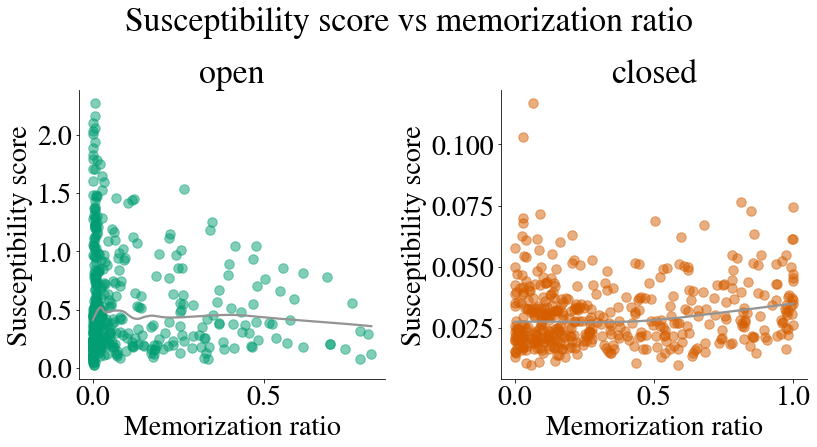

In [ ]:
# matplotlib.rcParams["font.size"] = "30"
colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
scatter_kws = {"s": 90, "alpha": 0.5}

qid_to_dfs_with_mr = dict(
    sorted(
        {
            qid: df
            for qid, df in qid_to_val_df_per_qe.items()
            if "sampled_mr" in df.columns
        }.items()
    )
)
qid_df_mr_all = pd.concat(list(qid_to_dfs_with_mr.values()), axis=0)
qid_df_mr_all_grouped = (
    qid_df_mr_all.groupby(["q_id", "query_form", "query_type", "type"])
    .agg({"susceptibility_score": "mean", "sampled_mr": "mean"})
    .reset_index()
)

for i, qt in enumerate(
    sorted(qid_df_mr_all_grouped["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.regplot(
        data=qid_df_mr_all_grouped[qid_df_mr_all_grouped["query_type"] == qt],
        x="sampled_mr",
        y="susceptibility_score",
        # hue="query_type",
        # legend=None,
        lowess=True,
        ax=ax,
        line_kws={"color": LINE_COLOR},
        scatter_kws={**scatter_kws, "color": colormap[qt]},
    )
    ax.set_title(qt)
    ax.set_xlabel("Memorization ratio")
    ax.set_ylabel("Susceptibility score")

fig.suptitle("Susceptibility score vs memorization ratio", y=0.92)
plt.tight_layout()
plot_name = "plot_susscore_vs_mr_open_closed_all_queries"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

### Comparison to MR - persuasion

Hypothesis: is the mean persuasion score for contexts where the model followed the context answer higher than the mean persuasion score for contexts where the model followed the OG answer?

$$H_0: \mathrm{mean}(\pi(x_c)) \leq \mathrm{mean}(\pi(x_o))$$
$$H_A: \mathrm{mean}(\pi(x_c)) > \mathrm{mean}(\pi(x_o))$$

where $x_c$ is the set of context-entity-pairs where the model chose to answer with the context-based answer and $x_o$ is the set of context-entity-pairs where the model chose to answer with the original memorized answer.

Given a query, we have $|C| \times |E|$ context-entity pairs (where $C$ is the set of contexts, $E$ is the set of entities). We partition this into group $\mathcal{C}$ (the contexts where the model chose to follow the context) and group $\mathcal{O}$ (the contexts where the model chose to follow the original memorized answer).

We run a permutation test for whether $\mathrm{mean}(\mathcal{C}) > \mathrm{mean}(\mathcal{O})$, for each of the queries.

In [ ]:
val_df_per_qe = next(iter(qid_to_val_df_per_qe.items()))[1]

In [ ]:
def explode_val_df_per_qe(val_df_per_qe):
    if isinstance(val_df_per_qe["sampled_answergroups"].iloc[0], str):
        val_df_per_qe["sampled_answergroups"] = val_df_per_qe[
            "sampled_answergroups"
        ].apply(literal_eval)

    val_df_per_qe["combined"] = val_df_per_qe.apply(
        lambda row: list(
            zip(
                row["contexts"],
                row["persuasion_scores_kl"],
                row["sampled_answergroups"],
            )
        ),
        axis=1,
    )
    exploded_df = pd.DataFrame(val_df_per_qe.explode("combined"))
    exploded_df[["context", "p_score", "sampled_answergroup"]] = pd.DataFrame(
        exploded_df["combined"].tolist(), index=exploded_df.index
    )
    exploded_df.drop(columns=["combined"], inplace=True)
    val_df_per_qe.drop(columns=["combined"], inplace=True)

    return exploded_df

In [ ]:
set(qid_to_val_df_per_qe).difference(set(qid_to_dfs_with_mr))

{'http://schema.org/address',
 'http://schema.org/duration',
 'http://schema.org/humanDevelopmentIndex',
 'http://schema.org/lyricist',
 'http://schema.org/manufacturer',
 'http://schema.org/musicBy',
 'http://schema.org/neighbors',
 'http://schema.org/numberOfEmployees',
 'http://schema.org/numberOfEpisodes',
 'http://schema.org/numberOfPages',
 'http://schema.org/populationNumber',
 'http://yago-knowledge.org/resource/studentsCount'}

In [ ]:
for qid, df in qid_to_dfs_with_mr.items():
    if isinstance(df["sampled_answergroups"].iloc[0], str):
        print(qid)
        df["sampled_answergroups"] = df["sampled_answergroups"].apply(literal_eval)
        qid_to_dfs_with_mr[qid] = df

In [ ]:
# # Closed queries - plot persuasion scores vs sampled answer group for all queries
# qid_to_dfs_with_mr = dict(
#     sorted(
#         {
#             qid: df
#             for qid, df in qid_to_val_df_per_qe.items()
#             if "sampled_mr" in df.columns
#         }.items()
#     )
# )
# num_qids = len(qid_to_dfs_with_mr)
# ncols = 4
# nrows = math.ceil(num_qids / ncols)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7))
# for i, (qid, df) in tqdm(enumerate(qid_to_dfs_with_mr.items())):
#     row, col = i // ncols, i % ncols
#     qt_df = df[df["query_type"] == "closed"]
#     exploded_df = explode_val_df_per_qe(qt_df)
#     ax = axes[row, col]
#     sns.violinplot(exploded_df, x="sampled_answergroup", y="p_score", ax=ax)
#     ax.set_title(qid)
#     # x = df["susceptibility_score"]
#     # x = sm.add_constant(x)
#     # y = df["sampled_mr"]
#     # ols_model = sm.OLS(y, x).fit()
#     # ols_model.summary()
# plt.tight_layout()
# plot_name = "plot_pscore_vs_answergroup_closed_all"
# save_path = os.path.join(analysis_dir, f"{plot_name}.png")
# fig.savefig(save_path)
# wandb.log({plot_name: wandb.Image(fig)})

In [ ]:
exploded_df_all = explode_val_df_per_qe(
    pd.concat(list(qid_to_dfs_with_mr.values()), axis=0)
)

In [ ]:
qid_to_exploded_df = {
    qid: exploded_df_all[exploded_df_all["q_id"] == qid]
    for qid in tqdm(exploded_df_all["q_id"].unique())
}

100%|██████████| 110/110 [02:06<00:00,  1.15s/it]


In [ ]:
from analysis_helpers import compute_ttest_scores_dfs, count_num_significant_queries

In [ ]:
ttest_res_open_p_df, ttest_res_closed_p_df = compute_ttest_scores_dfs(
    qid_to_exploded_df,
    group1=0,
    group2=1,
    score_col="p_score",
    type_col="sampled_answergroup",
    permutations=5000,
)

100%|██████████| 110/110 [15:48<00:00,  8.63s/it]


In [ ]:
ttest_res_open_p_df

,query,effect_size,p_value,n,bh_adj_p_value
0,http://schema.org/about,-1.238701,0.0,1864,0.0
1,http://yago-knowledge.org/resource/parentBody,-0.483614,0.0,5149,0.0
2,http://yago-knowledge.org/resource/notableWork,-1.282184,0.0,4485,0.0
3,http://yago-knowledge.org/resource/mass,-0.194425,0.0,5733,0.0
4,http://yago-knowledge.org/resource/follows,-0.812828,0.0,1518,0.0
...,...,...,...,...,...
99,http://yago-knowledge.org/resource/luminosity,0.400266,1.0,5625,1.0
100,http://schema.org/locationCreated,0.243528,1.0,7483,1.0
101,http://yago-knowledge.org/resource/academicDegree,0.434888,1.0,8558,1.0
102,http://schema.org/material,0.568029,1.0,5634,1.0


In [ ]:
# Number and proportion of queries that are significant
print(
    "Open:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_open_p_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)
print("\n")
print(
    "Closed:\n"
    + json.dumps(
        count_num_significant_queries(
            ttest_res_closed_p_df,
            col_name="bh_adj_p_value",
            alpha=0.05,
            alternative="less",
        ),
        indent=2,
    ),
)

Open:
{
  "count": {
    "less": 75,
    "insignificant": 29
  },
  "proportion": {
    "less": 0.7211538461538461,
    "insignificant": 0.27884615384615385
  }
}


Closed:
{
  "count": {
    "less": 32,
    "insignificant": 78
  },
  "proportion": {
    "less": 0.2909090909090909,
    "insignificant": 0.7090909090909091
  }
}


In [ ]:
exploded_df_all[
    (exploded_df_all["q_id"] == "http://schema.org/about")
    & (exploded_df_all["query_type"] == "open")
    & (exploded_df_all["sampled_answergroup"] == 1)
], exploded_df_all[
    (exploded_df_all["q_id"] == "http://schema.org/about")
    & (exploded_df_all["query_type"] == "open")
    & (exploded_df_all["sampled_answergroup"] == 0)
]

(                        q_id                        query_form  \
 203  http://schema.org/about  Q: What is '{entity}' about?\nA:   
 203  http://schema.org/about  Q: What is '{entity}' about?\nA:   
 211  http://schema.org/about  Q: What is '{entity}' about?\nA:   
 213  http://schema.org/about  Q: What is '{entity}' about?\nA:   
 213  http://schema.org/about  Q: What is '{entity}' about?\nA:   
 ..                       ...                               ...   
 399  http://schema.org/about               '{entity}' is about   
 399  http://schema.org/about               '{entity}' is about   
 399  http://schema.org/about               '{entity}' is about   
 399  http://schema.org/about               '{entity}' is about   
 399  http://schema.org/about               '{entity}' is about   
 
                                                 entity              answer  \
 203  (Indiana Jones and the Kingdom of the Crystal ...            Cold War   
 203  (Indiana Jones and the Kingdom

In [ ]:
mean_pscore_per_answergroup = (
    exploded_df_all.groupby(["q_id", "query_form", "query_type", "sampled_answergroup"])
    .agg({"p_score": "mean"})
    .reset_index()
)

In [ ]:
from measuring.utils import AnswerGroup

In [ ]:
answergroup_to_presentable = {
    AnswerGroup.ORIGINAL.value: "Original",
    AnswerGroup.CONTEXT.value: "Context",
    AnswerGroup.OTHER.value: "Other",
}
mean_pscore_per_answergroup["presentable_answergroup"] = mean_pscore_per_answergroup[
    "sampled_answergroup"
].apply(lambda x: answergroup_to_presentable[x])

In [ ]:
mean_pscore_per_answergroup

,q_id,query_form,query_type,sampled_answergroup,p_score,presentable_answergroup
0,http://schema.org/about,'{entity}' is about,open,0,0.944119,Original
1,http://schema.org/about,'{entity}' is about,open,1,1.633259,Context
2,http://schema.org/about,'{entity}' is about,open,2,0.957347,Other
3,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,0,0.038383,Original
4,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,1,0.037757,Context
...,...,...,...,...,...,...
1235,reverse-http://yago-knowledge.org/resource/ter...,Q: What is {entity} the terminus of?\nA:,open,1,0.878782,Context
1236,reverse-http://yago-knowledge.org/resource/ter...,Q: What is {entity} the terminus of?\nA:,open,2,0.464488,Other
1237,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,open,0,1.924648,Original
1238,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,open,1,1.964020,Context


In [ ]:
mean_pscore_per_answergroup[mean_pscore_per_answergroup["query_type"] == qt]

,q_id,query_form,query_type,sampled_answergroup,p_score,presentable_answergroup
3,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,0,0.038383,Original
4,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,1,0.037757,Context
5,http://schema.org/about,Q: Does {answer} pertain to '{entity}'?\nA:,closed,2,0.036486,Other
6,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,closed,0,0.035357,Original
7,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,closed,1,0.032424,Context
...,...,...,...,...,...,...
1229,reverse-http://yago-knowledge.org/resource/ter...,Q: Is the terminus of {answer} {entity}?\nA:,closed,0,0.029931,Original
1230,reverse-http://yago-knowledge.org/resource/ter...,Q: Is the terminus of {answer} {entity}?\nA:,closed,1,0.028598,Context
1231,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,closed,0,0.022926,Original
1232,reverse-http://yago-knowledge.org/resource/ter...,Q: Is {entity} the terminus of {answer}?\nA:,closed,1,0.020362,Context


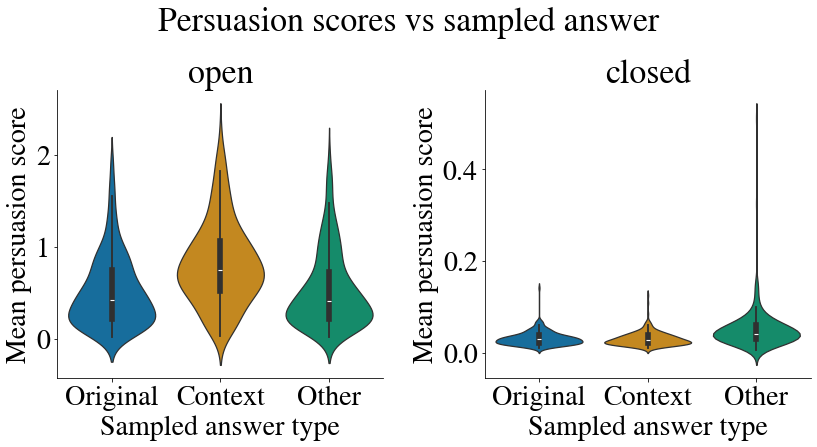

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
for i, qt in enumerate(
    sorted(mean_pscore_per_answergroup["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.violinplot(
        data=mean_pscore_per_answergroup[
            mean_pscore_per_answergroup["query_type"] == qt
        ],
        x="presentable_answergroup",
        y="p_score",
        hue="presentable_answergroup",
        # size=10,
        # dodge=True,
        ax=ax,
    )
    ax.set_title(qt)
    ax.set_xlabel("Sampled answer type")
    ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores vs sampled answer",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_sampled_answer_agg_ents_and_queries_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")